In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import langid
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

In [ ]:
books = pd.read_csv('goodbooks-10k/books_enriched.csv')
books = books.drop(columns=['Unnamed: 0', 'authors_2', 'index', 'image_url', 'small_image_url', 'isbn', 'isbn13', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'language_code', 'publishDate'])

In [ ]:
books = books.dropna(subset=['description'])
books['language'] = books['description'].apply(lambda x: langid.classify(x)[0])
books = books[books['language'] == 'en']
books = books.drop(columns=['language'])
books.head()

In [ ]:
books.info()

In [ ]:
df = books.loc[:, ['average_rating', 'ratings_count', 'genres', 'description']]

genres: set = set()
for row in df['genres']:
    curr = row.split("'")
    for i in range(1, len(curr), 2):
        genres.add(curr[i])

In [ ]:
genre_counts = {}

for genre in genres:
    df[genre] = df['genres'].apply(lambda x: genre in x)
    
    genre_counts[genre] = df[genre].sum()
    
    if df[genre].sum() < 100:
        df = df.drop(columns=[genre])
df = df.drop(columns=['genres'])

In [ ]:
df.info()

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def get_embedding(text: str) -> np.ndarray:
    return model.encode(text)

df['description'] = df['description'].apply(lambda x: get_embedding(x))

In [ ]:
numeric = df.loc[:, ['average_rating', 'ratings_count']]
scaler = StandardScaler()
numeric = scaler.fit_transform(numeric)

In [ ]:
boolean = df.drop(columns=['average_rating', 'ratings_count', 'description'])

In [ ]:
normalized_embeddings = normalize(np.array(df['description'].tolist()))

In [ ]:
K = np.concatenate((numeric, boolean.to_numpy(), normalized_embeddings), axis=1)

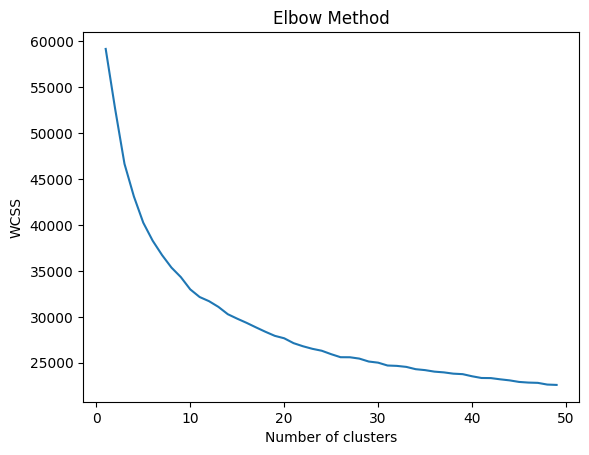

[np.float64(0.11103180123032462), np.float64(0.11773643651463303), np.float64(0.12875369270255116), np.float64(0.1375942933200586), np.float64(0.1339386861881589), np.float64(0.12489759014634712), np.float64(0.1241474179532484), np.float64(0.11943464883462962), np.float64(0.1198444316230522), np.float64(0.12032888711567649), np.float64(0.12189387912434961), np.float64(0.11746880027445351), np.float64(0.11117028296586597), np.float64(0.10775696968626744), np.float64(0.10203206381170668), np.float64(0.10605582185047792), np.float64(0.10932295450858025), np.float64(0.10751179512996868), np.float64(0.10217875231827135), np.float64(0.10565692690517416), np.float64(0.10401736483098462), np.float64(0.10549584588221295), np.float64(0.1026334485430771), np.float64(0.10570786581933997), np.float64(0.10267103697347432), np.float64(0.10439258647989975), np.float64(0.09784673529123045), np.float64(0.09798558342259325), np.float64(0.09046082736724168), np.float64(0.09811880707947364), np.float64(0.0

In [63]:
# elbow method
wcss = []
silhouette = []
for i in range(2, 50):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(K)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 50), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
print(silhouette)

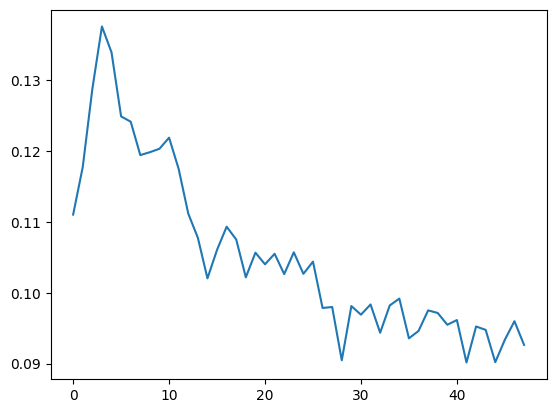

np.int64(3)

In [65]:
plt.plot(silhouette)
plt.show()
np.argmax(silhouette)

In [67]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(K)

KMeans(n_clusters=5)

In [68]:
df['cluster'] = kmeans.labels_
df.head()

,average_rating,ratings_count,description,art,books,chick-lit,suspense,spirituality,historical-fiction,comics,...,business,travel,poetry,christian,history,psychology,mystery,religion,classics,cluster
0,4.34,4780653,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,4
1,4.44,4602479,Harry Potter's life is miserable. His parents ...,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,4
2,3.57,3866839,About three things I was absolutely positive.\...,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,4
3,4.25,3198671,The unforgettable novel of a childhood in a sl...,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,4
4,3.89,2683664,Alternate Cover Edition ISBN: 0743273567 (ISBN...,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,4


(array([1481.,    0., 1609.,    0.,    0., 4013.,    0., 2573.,    0.,
          68.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

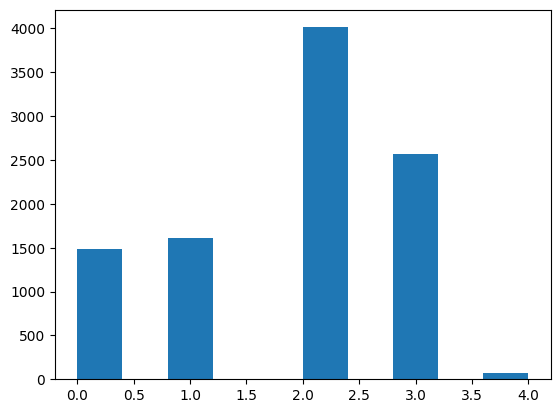

In [69]:
plt.hist(df['cluster'])

In [59]:
import pprint
pprint.pprint(sorted(genre_counts.items(), key=lambda x: x[1], reverse=True))

[('fiction', np.int64(9467)),
 ('fantasy', np.int64(3666)),
 ('romance', np.int64(3231)),
 ('contemporary', np.int64(2859)),
 ('young-adult', np.int64(2703)),
 ('mystery', np.int64(2439)),
 ('classics', np.int64(2018)),
 ('thriller', np.int64(1789)),
 ('science', np.int64(1759)),
 ('historical-fiction', np.int64(1754)),
 ('nonfiction', np.int64(1594)),
 ('crime', np.int64(1463)),
 ('suspense', np.int64(1424)),
 ('science-fiction', np.int64(1403)),
 ('paranormal', np.int64(1294)),
 ('chick-lit', np.int64(1256)),
 ('horror', np.int64(856)),
 ('history', np.int64(836)),
 ('biography', np.int64(804)),
 ('books', np.int64(729)),
 ('memoir', np.int64(650)),
 ('philosophy', np.int64(575)),
 ('psychology', np.int64(489)),
 ('religion', np.int64(464)),
 ('graphic-novels', np.int64(452)),
 ('comics', np.int64(433)),
 ('self-help', np.int64(425)),
 ('spirituality', np.int64(312)),
 ('christian', np.int64(291)),
 ('business', np.int64(273)),
 ('poetry', np.int64(260)),
 ('art', np.int64(213)),
 ('

In [ ]:
genre_groups = {"fiction": ['fiction', 'contemporary', 'classics', 'chick-lit', 'romance', 'young-adult', 'historical-fiction'],
                "speculative": ['fantasy', 'science-fiction', 'paranormal', 'thriller', 'suspense', 'horror', 'mystery', 'crime'],
                "non-fiction": ["nonfiction", "history", "science", "biography", "memoir", "philosophy", "psychology", "self-help", "religion", "spirituality", "christian", "business", "travel"],
                "graphic-and-visual": ["graphic-novels", "comics", "art", "manga"]}